
# Healthcare Patient Analytics — Notebook

This notebook reproduces and extends the **Healthcare Summary Report** using the dataset in `Healthcare Data.xlsx`.

**You will get:**
- Cleaned and standardized data
- Derived fields: **Age Group, BMI Category, Blood Pressure Category, Diabetes Flag**
- KPIs and visuals mirroring the dashboard (Diabetic vs Non‑Diabetic, BP categories, BMI mix, BMI by Age Group, BP × Diabetes)
- **Tableau‑ready CSV exports** for each visual

> The notebook is resilient to minor column‑name differences: it will attempt to **auto‑detect** common variants like `Outcome/Diabetic`, `Blood Pressure` as `120/80`, separate `Systolic/Diastolic`, etc.


## 1) Setup

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

plt.rcParams['figure.figsize'] = (11, 6)
plt.rcParams['axes.grid'] = True

DATA_CANDIDATES = [
    Path("Healthcare Data.xlsx"),
    Path("Healthcare Data.xlsx")  # uploaded path (fallback in this environment)
]

EXPORT_DIR = Path("exports")
EXPORT_DIR.mkdir(exist_ok=True, parents=True)

def find_dataset(paths):
    for p in paths:
        if p.exists():
            return p
    raise FileNotFoundError("Place 'Healthcare Data.xlsx' in ./data/ or provide a valid path.")

DATA_PATH = find_dataset(DATA_CANDIDATES)
DATA_PATH


WindowsPath('Healthcare Data.xlsx')

## 2) Load Data & Standardize Columns

In [2]:

df = pd.read_excel(DATA_PATH)

def std_col(c):
    c = str(c).strip().replace("\n", " ").replace("\r", " ")
    c = re.sub(r"\s+", "_", c)
    return c.upper()

df.columns = [std_col(c) for c in df.columns]
print("Columns:", list(df.columns))
print("Shape:", df.shape)

# Peek
df.head()


Columns: ['ID', 'AGE', 'BLOOD_PRESSURE_SYSTOLIC', 'BMI', 'DIABETES_PEDIGREE_FUNCTION', 'GLUCOSE', 'INSULIN', 'OUTCOME', 'SKIN_THICKNESS']
Shape: (768, 9)


,ID,AGE,BLOOD_PRESSURE_SYSTOLIC,BMI,DIABETES_PEDIGREE_FUNCTION,GLUCOSE,INSULIN,OUTCOME,SKIN_THICKNESS
0,1,50,Normal,33.6,0.627,148,0,1,35
1,2,31,Normal,26.6,0.351,85,0,0,29
2,3,32,Normal,23.3,0.672,183,0,1,0
3,4,21,Normal,28.1,0.167,89,94,0,23
4,5,33,Normal,43.1,2.288,137,168,1,35


## 3) Map Columns (auto‑detect common variants)

In [3]:

# Candidate name lists for each semantic field
CANDS = {
    "AGE": ["AGE"],
    "GENDER": ["GENDER", "SEX"],
    "BMI": ["BMI", "BODY_MASS_INDEX"],
    "GLUCOSE": ["GLUCOSE"],
    "OUTCOME": ["OUTCOME", "DIABETES", "DIABETIC", "IS_DIABETIC", "DIABETES_OUTCOME"],
    "BP_SYS": ["SYSTOLIC", "BP_SYSTOLIC", "SYSTOLIC_BP"],
    "BP_DIA": ["DIASTOLIC", "BP_DIASTOLIC", "DIASTOLIC_BP"],
    "BP_STR": ["BLOOD_PRESSURE", "BP"],  # could be string "120/80"
    "BP_CATEGORY": ["BLOOD_PRESSURE_CATEGORY", "BP_CATEGORY", "BP_STATUS"],
}

def pick(cols, cands):
    for name in cands:
        if name in cols:
            return name
    return None

colmap = {k: pick(df.columns, v) for k, v in CANDS.items()}
colmap


{'AGE': 'AGE',
 'GENDER': None,
 'BMI': 'BMI',
 'GLUCOSE': 'GLUCOSE',
 'OUTCOME': 'OUTCOME',
 'BP_SYS': None,
 'BP_DIA': None,
 'BP_STR': None,
 'BP_CATEGORY': None}

## 4) Derive `DIABETES_FLAG`

In [4]:

diab_flag = None
if colmap["OUTCOME"] and df[colmap["OUTCOME"]].notna().any():
    ser = df[colmap["OUTCOME"]]
    if ser.dropna().astype(str).str.upper().isin(["0","1"]).all():
        diab_flag = ser.astype(int)
    else:
        # map common values
        m = ser.astype(str).str.strip().str.upper().map({
            "1":"1","0":"0","YES":"1","NO":"0","Y":"1","N":"0","DIABETIC":"1",
            "NON-DIABETIC":"0","NONDIABETIC":"0","TRUE":"1","FALSE":"0"
        })
        diab_flag = m.fillna("0").astype(int)
else:
    diab_flag = pd.Series([np.nan]*len(df), index=df.index, dtype="float")

df["DIABETES_FLAG"] = diab_flag
df["DIABETES_LABEL"] = df["DIABETES_FLAG"].map({1:"Diabetic", 0:"Non-Diabetic"})
df["DIABETES_LABEL"] = df["DIABETES_LABEL"].fillna("Unknown")

df["DIABETES_LABEL"].value_counts(dropna=False)


DIABETES_LABEL
Non-Diabetic    500
Diabetic        268
Name: count, dtype: int64

## 5) Normalize Blood Pressure

In [5]:

def parse_bp_string(s):
    # accepts like "120/80" or "120-80"
    if pd.isna(s): 
        return (np.nan, np.nan)
    s = str(s)
    m = re.search(r"(\d+)\D+(\d+)", s)
    if m:
        return (float(m.group(1)), float(m.group(2)))
    return (np.nan, np.nan)

if colmap["BP_SYS"] and colmap["BP_DIA"]:
    df["BP_SYS"] = pd.to_numeric(df[colmap["BP_SYS"]], errors="coerce")
    df["BP_DIA"] = pd.to_numeric(df[colmap["BP_DIA"]], errors="coerce")
elif colmap["BP_STR"]:
    pairs = df[colmap["BP_STR"]].apply(parse_bp_string)
    df["BP_SYS"] = pairs.map(lambda x: x[0])
    df["BP_DIA"] = pairs.map(lambda x: x[1])
else:
    df["BP_SYS"] = np.nan
    df["BP_DIA"] = np.nan

df[["BP_SYS","BP_DIA"]].head()


,BP_SYS,BP_DIA
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


## 6) Blood Pressure Category

In [6]:

def aha_bp_category(sys, dia):
    # American Heart Association categories + Low category for very low BP
    if pd.isna(sys) or pd.isna(dia):
        return np.nan
    if sys < 90 or dia < 60:
        return "Low"
    if sys < 120 and dia < 80:
        return "Normal"
    if 120 <= sys < 130 and dia < 80:
        return "Elevated"
    if (130 <= sys < 140) or (80 <= dia < 90):
        return "High"
    if (140 <= sys) or (90 <= dia):
        return "High"
    return "High"

if colmap["BP_CATEGORY"]:
    cat = df[colmap["BP_CATEGORY"]].astype(str).str.strip().str.title()
else:
    cat = [aha_bp_category(s, d) for s,d in zip(df["BP_SYS"], df["BP_DIA"])]
    cat = pd.Series(cat, index=df.index)

df["BP_CATEGORY"] = cat.fillna("Unknown")
df["BP_CATEGORY"].value_counts(dropna=False)


BP_CATEGORY
Unknown    768
Name: count, dtype: int64

## 7) BMI Category

In [7]:

bmi_col = colmap["BMI"]
if bmi_col is None:
    # attempt to compute BMI if Height/Weight exist (rare). Otherwise keep NaN.
    df["BMI"] = pd.NA
else:
    df["BMI"] = pd.to_numeric(df[bmi_col], errors="coerce")

def bmi_bucket(bmi):
    if pd.isna(bmi): 
        return "Unknown"
    if bmi < 18.5: 
        return "Underweight"
    if bmi < 25: 
        return "Healthy Weight"
    if bmi < 30: 
        return "Overweight"
    return "Obese"

df["BMI_CATEGORY"] = df["BMI"].apply(bmi_bucket)
df["BMI_CATEGORY"].value_counts(dropna=False)


BMI_CATEGORY
Obese             472
Overweight        179
Healthy Weight    103
Underweight        14
Name: count, dtype: int64

## 8) Age Group (5‑year bands, 20 to 75+)

In [8]:

age_col = colmap["AGE"]
if age_col:
    df["AGE"] = pd.to_numeric(df[age_col], errors="coerce")
else:
    df["AGE"] = np.nan

bins = list(range(20, 80, 5)) + [200]
labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-2)] + ["75+"]
df["AGE_GROUP"] = pd.cut(df["AGE"], bins=bins, labels=labels, right=False, include_lowest=True)
df["AGE_GROUP"] = df["AGE_GROUP"].astype(str).replace("nan", "Unknown")

df["AGE_GROUP"].value_counts().head()


AGE_GROUP
20-24    219
25-29    177
30-34     92
40-44     74
35-39     73
Name: count, dtype: int64

## 9) KPIs

In [9]:

total_patients = len(df)
diab_share = (df["DIABETES_FLAG"]==1).mean() if df["DIABETES_FLAG"].notna().any() else np.nan
kpis = {
    "Total Patients": int(total_patients),
    "Diabetic %": float(diab_share*100) if pd.notna(diab_share) else np.nan,
}

bp_counts = df["BP_CATEGORY"].value_counts()
kpis["BP Category Counts"] = bp_counts.to_dict()

kpis


{'Total Patients': 768,
 'Diabetic %': 34.89583333333333,
 'BP Category Counts': {'Unknown': 768}}

## 10) Visual — Diabetic vs Non‑Diabetic Patients

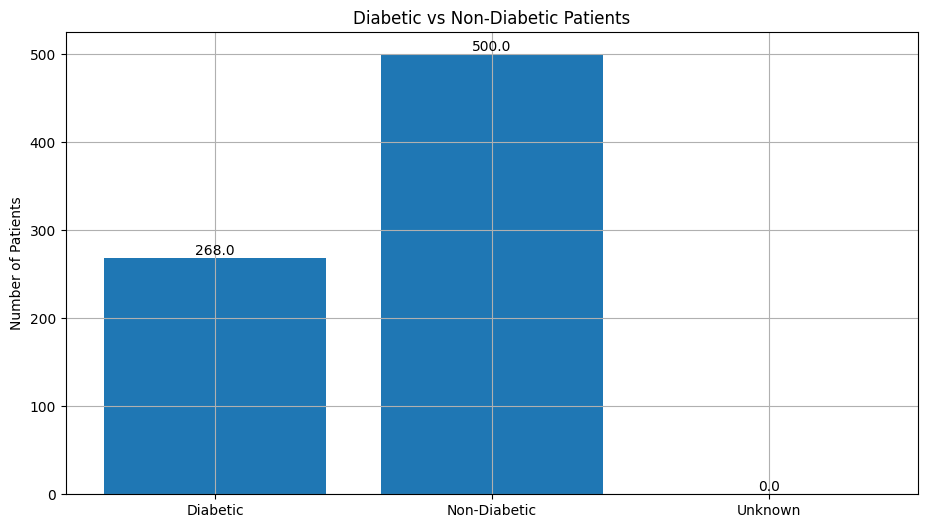

In [10]:

counts = df["DIABETES_LABEL"].value_counts().reindex(["Diabetic","Non-Diabetic","Unknown"]).fillna(0)
fig, ax = plt.subplots()
ax.bar(counts.index, counts.values)
ax.set_title("Diabetic vs Non‑Diabetic Patients")
ax.set_ylabel("Number of Patients")
for i, v in enumerate(counts.values):
    ax.text(i, v, f"{v}", ha="center", va="bottom")
plt.show()

# Export
counts.reset_index().rename(columns={"index":"DIABETES_LABEL", "DIABETES_LABEL":"COUNT"}).to_csv(EXPORT_DIR/"diabetes_counts.csv", index=False)


## 11) Visual — Patient Summary by Blood Pressure Category

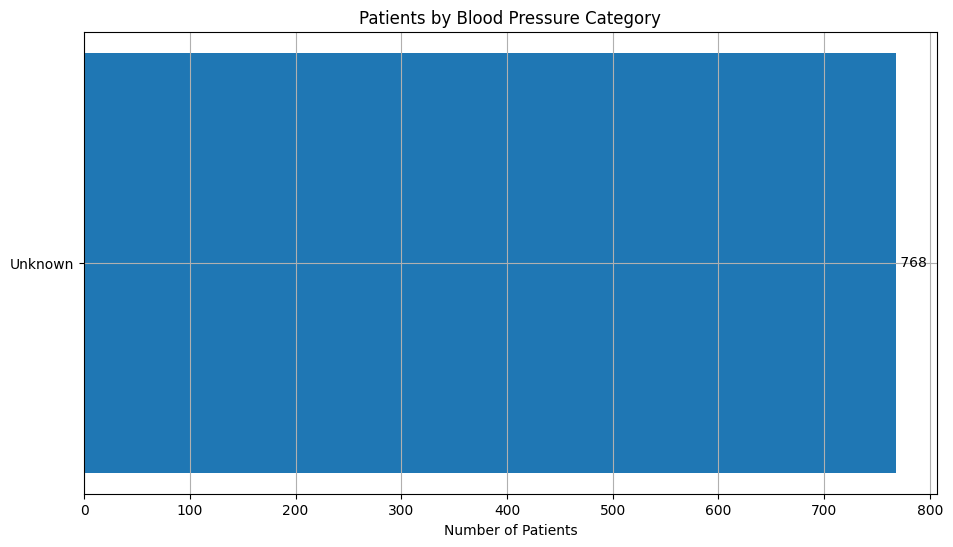

In [11]:

bp_summary = df["BP_CATEGORY"].value_counts().reset_index()
bp_summary.columns = ["BP_CATEGORY", "COUNT"]
fig, ax = plt.subplots()
ax.barh(bp_summary["BP_CATEGORY"], bp_summary["COUNT"])
ax.set_title("Patients by Blood Pressure Category")
ax.set_xlabel("Number of Patients")
for i, v in enumerate(bp_summary["COUNT"]):
    ax.text(v, i, f" {v}", va="center")
plt.show()

bp_summary.to_csv(EXPORT_DIR/"bp_category_counts.csv", index=False)


## 12) Visual — Patient Distribution by BMI Category

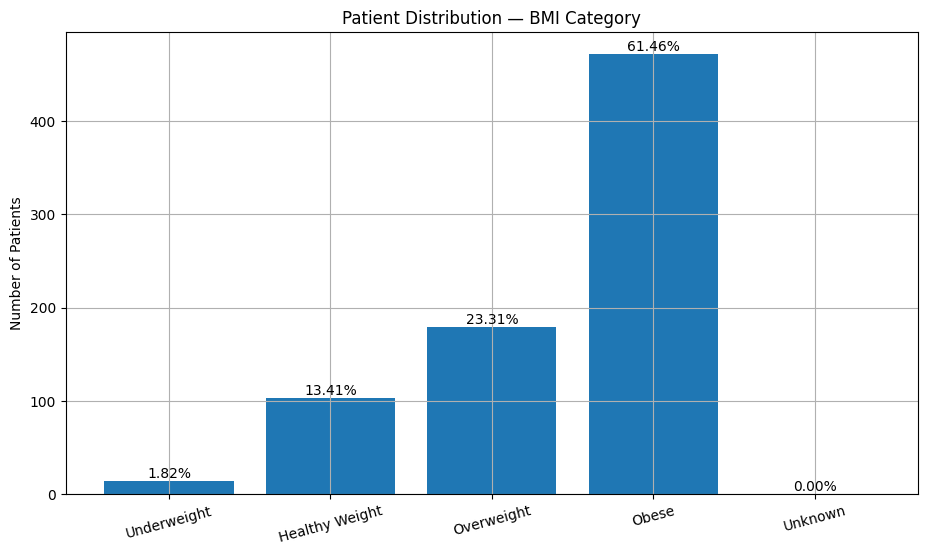

In [12]:

bmi_summary = df["BMI_CATEGORY"].value_counts().reindex(["Underweight","Healthy Weight","Overweight","Obese","Unknown"]).fillna(0).reset_index()
bmi_summary.columns = ["BMI_CATEGORY", "COUNT"]
total = bmi_summary["COUNT"].sum()
bmi_summary["PCT"] = (bmi_summary["COUNT"]/total*100).round(2)

fig, ax = plt.subplots()
ax.bar(bmi_summary["BMI_CATEGORY"], bmi_summary["COUNT"])
ax.set_title("Patient Distribution — BMI Category")
ax.set_ylabel("Number of Patients")
for i, (cnt, pct) in enumerate(zip(bmi_summary["COUNT"], bmi_summary["PCT"])):
    ax.text(i, cnt, f"{pct:.2f}%", ha="center", va="bottom")
plt.xticks(rotation=15)
plt.show()

bmi_summary.to_csv(EXPORT_DIR/"bmi_category_counts.csv", index=False)


## 13) Visual — BMI by Age Group (Average BMI)

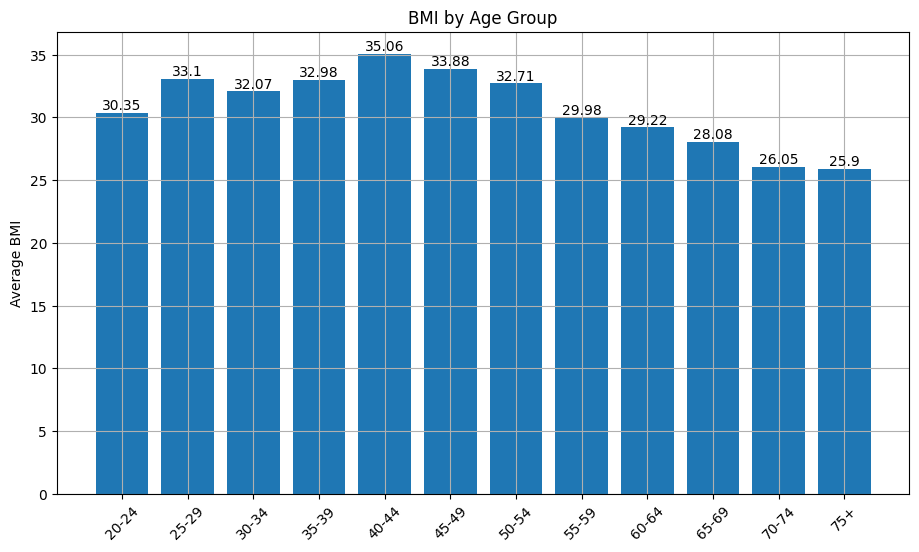

In [13]:

bmi_age = df.groupby("AGE_GROUP", dropna=False)["BMI"].mean().reset_index()
bmi_age["BMI"] = bmi_age["BMI"].round(2)

fig, ax = plt.subplots()
ax.bar(bmi_age["AGE_GROUP"], bmi_age["BMI"])
ax.set_title("BMI by Age Group")
ax.set_ylabel("Average BMI")
plt.xticks(rotation=45)
for i, v in enumerate(bmi_age["BMI"]):
    if not pd.isna(v):
        ax.text(i, v, f"{v}", ha="center", va="bottom")
plt.show()

bmi_age.to_csv(EXPORT_DIR/"bmi_by_age_group.csv", index=False)
